In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor


***Data Dividing***

In [4]:
import glob

chasedb1_path = '/media/mountHDD2/chasedb1'

image_files = glob.glob(chasedb1_path + '/*.jpg')
mask_files = glob.glob(chasedb1_path + '/*1stHO.png')

image_files.sort()
mask_files.sort()

img_dir = []
mask_dir = []

# Tạo danh sách các cặp (image, mask)
image_mask_pairs = [(image, mask) for image, mask in zip(image_files, mask_files)]

for pair in image_mask_pairs:
    img_dir.append(pair[0])  
    mask_dir.append(pair[1]) 

In [7]:
print(len(img_dir),len(mask_dir))

28 28


***Custorm Dataset***


In [8]:
class ChasedbT(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, target_transform=None):
        self.imgs = img_dir  
        self.msks = mask_dir 
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

In [9]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        #transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #The mean and std of ImageNet,Medical images must be counted separately 
    ]
)
#https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

Data_transfered = ChasedbT( img_dir=img_dir, mask_dir=mask_dir,transform = transform, target_transform=target_transform)
print(len(Data_transfered))

28


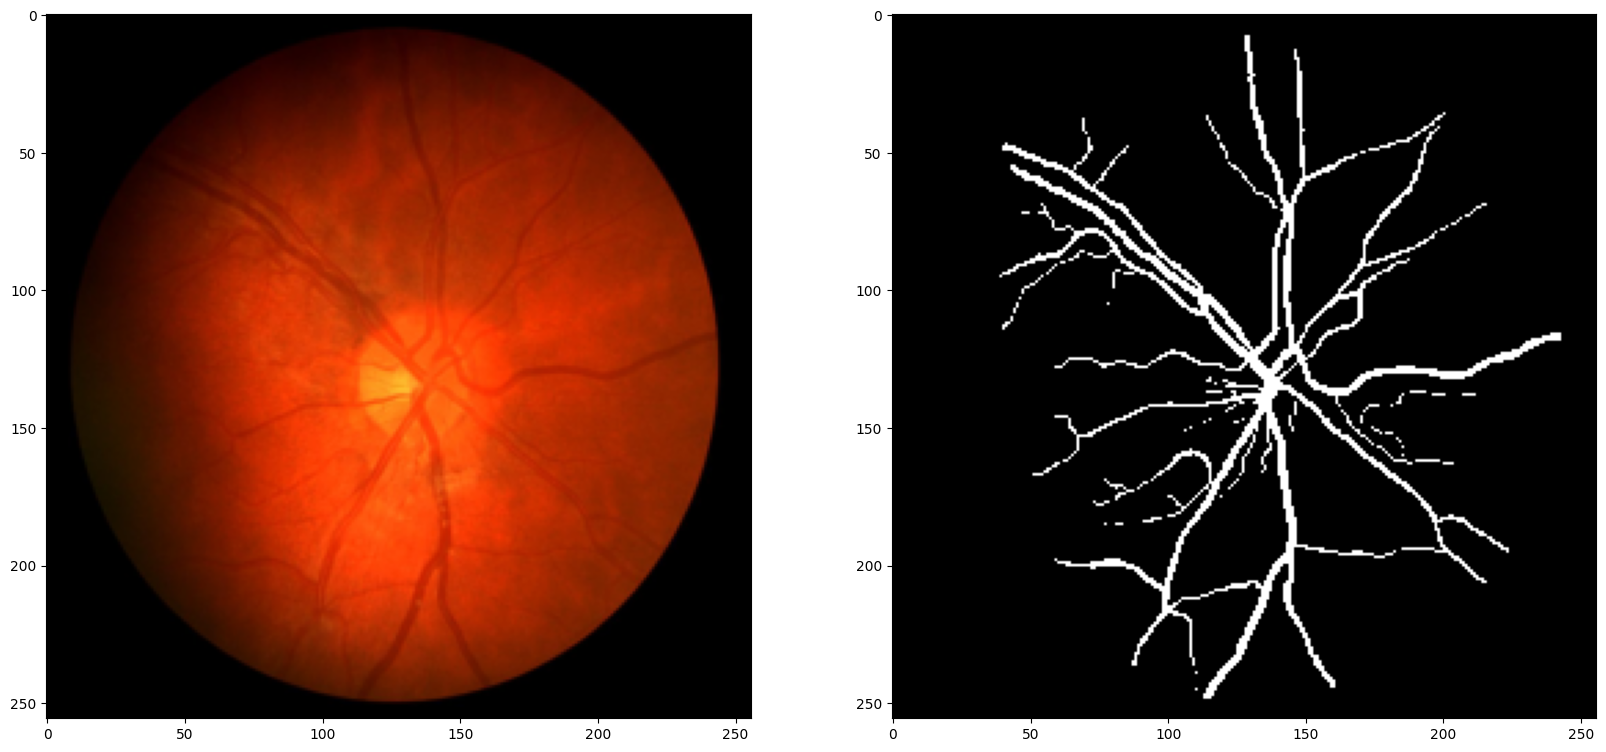

In [10]:

img, msk = Data_transfered[27]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20)) #tạo một figure chứa hai axes (ax1 và ax2) được sắp xếp theo hàng ngang với kích thước 20x20 inches
ax1.imshow(img.permute(1, -1, 0).numpy()) #Phương thức permute(1, -1, 0) được sử dụng để thay đổi chiều của tensor ,.numpy() chuyển đổi tensor thành mảng NumPy
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

In [11]:
from torch.utils.data.dataset import random_split
train_ds, test_ds = random_split(Data_transfered, [0.8, 0.2])

train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)

print("Training Samples: {}".format(len(train_ds)))
print("Testing Samples: {}".format(len(test_ds)))

Training Samples: 23
Testing Samples: 5


In [12]:
sample_data, sample_mask = train_ds[10]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")

print(f"Number classes: {np.unique(sample_mask.numpy())}")

data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])
Number classes: [0. 1.]


***Training***

In [14]:
class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

In [15]:
class Recurrent_block(nn.Module):
    def __init__(self, out_ch, t=2):
        super(Recurrent_block, self).__init__()

        self.t = t
        self.out_ch = out_ch
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        for i in range(self.t):
            if i == 0:
                x = self.conv(x)
            out = self.conv(x + x)
        return out


class RRCNN_block(nn.Module):
    def __init__(self, in_ch, out_ch, t=2):
        super(RRCNN_block, self).__init__()

        self.RCNN = nn.Sequential(
            Recurrent_block(out_ch, t=t),
            Recurrent_block(out_ch, t=t)
        )
        self.Conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x1 = self.Conv(x)
        x2 = self.RCNN(x1)
        out = x1 + x2
        return out

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [16]:
class R2AttU_Net(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, t=2, init_channels = 16):
        super(R2AttU_Net, self).__init__()

        n1 = init_channels
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.RRCNN1 = RRCNN_block(in_ch, filters[0], t=t)
        self.RRCNN2 = RRCNN_block(filters[0], filters[1], t=t)
        self.RRCNN3 = RRCNN_block(filters[1], filters[2], t=t)
        self.RRCNN4 = RRCNN_block(filters[2], filters[3], t=t)
        self.RRCNN5 = RRCNN_block(filters[3], filters[4], t=t)

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_RRCNN5 = RRCNN_block(filters[4], filters[3], t=t)

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_RRCNN4 = RRCNN_block(filters[3], filters[2], t=t)

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_RRCNN3 = RRCNN_block(filters[2], filters[1], t=t)

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_RRCNN2 = RRCNN_block(filters[1], filters[0], t=t)

        self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.RRCNN1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.RRCNN2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.RRCNN3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.RRCNN4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.RRCNN5(e5)

        d5 = self.Up5(e5)
        e4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((e4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        e3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        e2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        e1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        out = self.Conv(d2)

        return out

In [17]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [18]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)
#device = torch.device("cpu")
model = R2AttU_Net(3,1,2,16).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

loss_fn = nn.BCEWithLogitsLoss()

In [19]:
old_loss = 1e26
best_dct = None
last_dct = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_loss = loss_fn(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()        
        
        tr_total_loss += train_loss.cpu().item()        
            
    mean_train_loss = tr_total_loss/len(train_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
model.load_state_dict(best_dct)

100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  3.85it/s]


Epoch: 0 - TrainLoss: 0.5870177693988966


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.78it/s]


Epoch: 1 - TrainLoss: 0.33901545923689136


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.31it/s]


Epoch: 2 - TrainLoss: 0.2409884152205094


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.02it/s]


Epoch: 3 - TrainLoss: 0.18824785883012024


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.55it/s]


Epoch: 4 - TrainLoss: 0.14951762233091437


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.43it/s]


Epoch: 5 - TrainLoss: 0.128878989621349


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.56it/s]


Epoch: 6 - TrainLoss: 0.1133037313171055


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.10it/s]


Epoch: 7 - TrainLoss: 0.10496073183806046


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.76it/s]


Epoch: 8 - TrainLoss: 0.1003523135314817


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.90it/s]


Epoch: 9 - TrainLoss: 0.09484061566383942


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.95it/s]


Epoch: 10 - TrainLoss: 0.09407011840654456


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.31it/s]


Epoch: 11 - TrainLoss: 0.09033585534147594


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.15it/s]


Epoch: 12 - TrainLoss: 0.08728846518889717


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.20it/s]


Epoch: 13 - TrainLoss: 0.08675531459891278


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.05it/s]


Epoch: 14 - TrainLoss: 0.0841708238358083


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.96it/s]


Epoch: 15 - TrainLoss: 0.08297963958719502


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.16it/s]


Epoch: 16 - TrainLoss: 0.08102053954549458


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.62it/s]


Epoch: 17 - TrainLoss: 0.08012820197188336


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.46it/s]


Epoch: 18 - TrainLoss: 0.07723894715309143


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.17it/s]


Epoch: 19 - TrainLoss: 0.07541863053389218


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.42it/s]


Epoch: 20 - TrainLoss: 0.07429572275799254


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.65it/s]


Epoch: 21 - TrainLoss: 0.07263342922796374


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.61it/s]


Epoch: 22 - TrainLoss: 0.07355100062230359


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.06it/s]


Epoch: 23 - TrainLoss: 0.07216062931262929


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.66it/s]


Epoch: 24 - TrainLoss: 0.07070965433250302


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.55it/s]


Epoch: 25 - TrainLoss: 0.06888175917708356


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.53it/s]


Epoch: 26 - TrainLoss: 0.06739830760204274


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.76it/s]


Epoch: 27 - TrainLoss: 0.0657743401825428


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.18it/s]


Epoch: 28 - TrainLoss: 0.06459001791865929


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.54it/s]


Epoch: 29 - TrainLoss: 0.06451659358066061


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.44it/s]


Epoch: 30 - TrainLoss: 0.06568200967234114


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.57it/s]


Epoch: 31 - TrainLoss: 0.06251593743977339


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.44it/s]


Epoch: 32 - TrainLoss: 0.06143727040161257


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.61it/s]


Epoch: 33 - TrainLoss: 0.05906294496810954


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.27it/s]


Epoch: 34 - TrainLoss: 0.05916567616488622


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.76it/s]


Epoch: 35 - TrainLoss: 0.05807282095370085


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.82it/s]


Epoch: 36 - TrainLoss: 0.05569741356631984


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 23.48it/s]


Epoch: 37 - TrainLoss: 0.053615004148172295


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.05it/s]


Epoch: 38 - TrainLoss: 0.05321924177848775


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.58it/s]


Epoch: 39 - TrainLoss: 0.05177668530655944


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.96it/s]


Epoch: 40 - TrainLoss: 0.05096261721590291


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.50it/s]


Epoch: 41 - TrainLoss: 0.048253709531348686


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.22it/s]


Epoch: 42 - TrainLoss: 0.047490389288767525


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.98it/s]


Epoch: 43 - TrainLoss: 0.04963307374197504


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.46it/s]


Epoch: 44 - TrainLoss: 0.04989998496097067


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.04it/s]


Epoch: 45 - TrainLoss: 0.047916501274575356


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.43it/s]


Epoch: 46 - TrainLoss: 0.04703192704397699


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.75it/s]


Epoch: 47 - TrainLoss: 0.04419898581893548


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.85it/s]


Epoch: 48 - TrainLoss: 0.04445720642157223


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.31it/s]


Epoch: 49 - TrainLoss: 0.04267238841756531


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.86it/s]


Epoch: 50 - TrainLoss: 0.04298278446430746


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.75it/s]


Epoch: 51 - TrainLoss: 0.04244153736078221


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.17it/s]


Epoch: 52 - TrainLoss: 0.04167721226163532


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.27it/s]


Epoch: 53 - TrainLoss: 0.04006408244047476


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.13it/s]


Epoch: 54 - TrainLoss: 0.038742022507864494


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.89it/s]


Epoch: 55 - TrainLoss: 0.03905342065769693


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.62it/s]


Epoch: 56 - TrainLoss: 0.03961295594015847


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.27it/s]


Epoch: 57 - TrainLoss: 0.03919623476331648


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.29it/s]


Epoch: 58 - TrainLoss: 0.03926767846164496


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.21it/s]


Epoch: 59 - TrainLoss: 0.03490765627635562


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.66it/s]


Epoch: 60 - TrainLoss: 0.032841739528205086


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.66it/s]


Epoch: 61 - TrainLoss: 0.03228637916238412


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.12it/s]


Epoch: 62 - TrainLoss: 0.03411804908967536


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.91it/s]


Epoch: 63 - TrainLoss: 0.03336120242981807


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.88it/s]


Epoch: 64 - TrainLoss: 0.035651454378081406


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.89it/s]


Epoch: 65 - TrainLoss: 0.03352484706303348


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.57it/s]


Epoch: 66 - TrainLoss: 0.031938293219908424


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 26.32it/s]


Epoch: 67 - TrainLoss: 0.02988064021843931


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 24.77it/s]


Epoch: 68 - TrainLoss: 0.031082113151964935


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 26.73it/s]


Epoch: 69 - TrainLoss: 0.030996268048234608


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.54it/s]


Epoch: 70 - TrainLoss: 0.02909184611685898


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.08it/s]


Epoch: 71 - TrainLoss: 0.028752745817536892


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.70it/s]


Epoch: 72 - TrainLoss: 0.028686329479450764


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.34it/s]


Epoch: 73 - TrainLoss: 0.029226050104783928


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.96it/s]


Epoch: 74 - TrainLoss: 0.02762750754861728


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.45it/s]


Epoch: 75 - TrainLoss: 0.026263892407650532


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.18it/s]


Epoch: 76 - TrainLoss: 0.02461000297056592


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.61it/s]


Epoch: 77 - TrainLoss: 0.024324432825264725


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.91it/s]


Epoch: 78 - TrainLoss: 0.0249835604234882


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.46it/s]


Epoch: 79 - TrainLoss: 0.024790337309241295


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.89it/s]


Epoch: 80 - TrainLoss: 0.0248514165210983


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 25.31it/s]


Epoch: 81 - TrainLoss: 0.024152761244255562


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 26.73it/s]


Epoch: 82 - TrainLoss: 0.025946971838888916


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.71it/s]


Epoch: 83 - TrainLoss: 0.028838917694014053


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.78it/s]


Epoch: 84 - TrainLoss: 0.02788291766267756


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.76it/s]


Epoch: 85 - TrainLoss: 0.024691303382101265


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.17it/s]


Epoch: 86 - TrainLoss: 0.02366305110247239


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 26.01it/s]


Epoch: 87 - TrainLoss: 0.02285335731247197


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.75it/s]


Epoch: 88 - TrainLoss: 0.022552287691961163


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.16it/s]


Epoch: 89 - TrainLoss: 0.02178987893073455


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.32it/s]


Epoch: 90 - TrainLoss: 0.020413208428932274


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.94it/s]


Epoch: 91 - TrainLoss: 0.01918277201121268


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.48it/s]


Epoch: 92 - TrainLoss: 0.01944115316576284


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.25it/s]


Epoch: 93 - TrainLoss: 0.018769809044897556


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.40it/s]


Epoch: 94 - TrainLoss: 0.02003370792321537


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.20it/s]


Epoch: 95 - TrainLoss: 0.020963521350337112


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.42it/s]


Epoch: 96 - TrainLoss: 0.021831514313817024


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.60it/s]


Epoch: 97 - TrainLoss: 0.023438897955676784


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.71it/s]


Epoch: 98 - TrainLoss: 0.021317659431825512


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.49it/s]

Epoch: 99 - TrainLoss: 0.02104606819541558


<All keys matched successfully>

In [21]:
# Lưu parameters
torch.save(best_dct, 'parameter_rattunet_v1.pth')

In [1]:
#best_model = R2AttU_Net()  
#best_model.load_state_dict(torch.load('parameter_rattunet_v1.pth'))

In [23]:
test_img_dir= '/home/chuyenmt/Chuyen_explore-Copy1/Test_Drive'

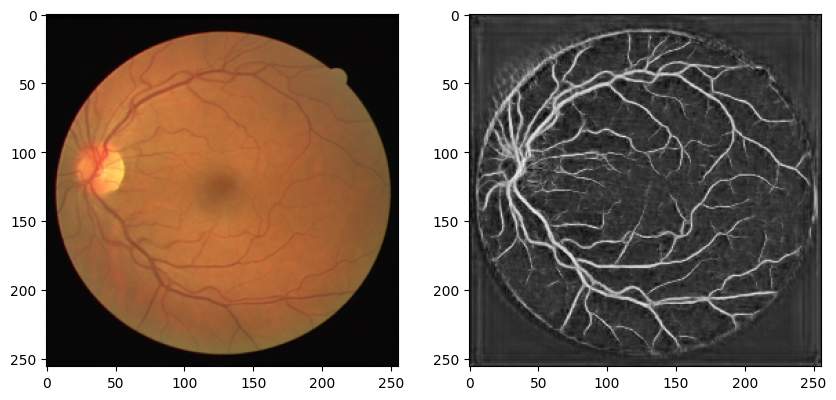

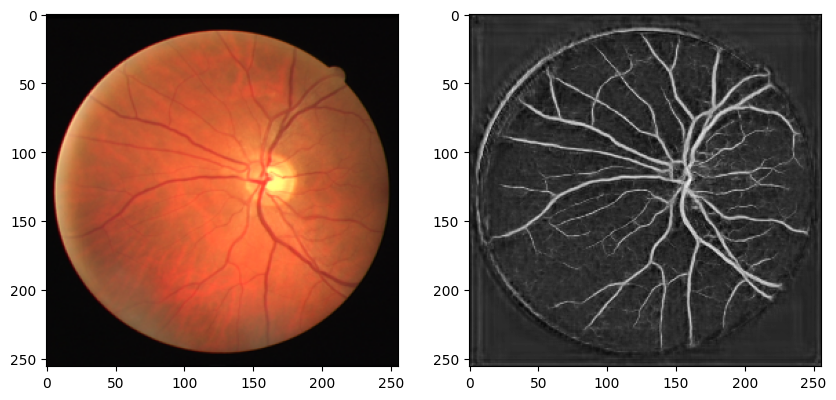

In [ ]:
from glob import glob
for test_img_path in glob(test_img_dir + "/*"):
    img = transform(Image.open(test_img_path)).to(device).unsqueeze(0)

    mask = model(img)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img[0].permute(1, -1, 0).detach().cpu().numpy())
    ax2.imshow(mask[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')
